# 1. Setup and get data

In [ ]:
import os
import utils
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
IMAGES_PATH = os.path.join('../data','images')
LABELS_PATH = os.path.join('../data','labels')
number_images = 3

In [ ]:
# creating folder if they aren't ready created
utils.create_folder(IMAGES_PATH)
utils.create_folder(LABELS_PATH)

## Capture picture from Cam

In [ ]:
utils.capture_picture(1,IMAGES_PATH)

## Labeling pictures captured
To consider:
1. select dir folder
2. change folder outputs and select ./data/labels

In [ ]:
#!labelme

# 2. Build Imagen Loading Function

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# Limit GPU memory growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load images into Tensorflow Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('../data/images/*.jpg')
# images.as_numpy_iterator().next() # test

In [ ]:
images = images.map(utils.load_image)
# images.as_numpy_iterator().next() #test

## View raw-images with matplotlib

In [ ]:
imagen_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = imagen_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented data

In [ ]:
folders_to_create_nivel_one = ['train','test','val']
folders_to_create_nivel_two = ['images','labels']
for folder_x in folders_to_create_nivel_one:
    utils.create_folder(os.path.join('../data',folder_x))
    for folder_y in folders_to_create_nivel_two:
        utils.create_folder(os.path.join('../data',folder_x,folder_y))

In [ ]:
# move matching labels
for folder in folders_to_create_nivel_one:
    for file in os.listdir(os.path.join('../data',folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('../data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('../data',folder,'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply imagen augmentation on images and labels

In [ ]:
import os
import json
import cv2
import numpy as np
import albumentations as alb

from matplotlib import pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1000, height=1000),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)

### Load a test image and annotation

In [ ]:
img = cv2.imread(os.path.join('../data','train','images','85a9e7b4-8fc4-11ed-859d-1a78c83c9571.jpg'))

In [ ]:
with open(os.path.join('../data','train','labels','85a9e7b4-8fc4-11ed-859d-1a78c83c9571.json'), 'r') as f:
    label = json.load(f)
#print(label)
label['shapes'][0]['points']

### Extract coordinates and rescale to match imagen resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

In [ ]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))
coords

### Apply augmentations and view results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['pit_ql'])

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [1000,1000]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1000,1000]).astype(int)),
              (255,0,0), 2)
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

In [1]:
import tensorflow as tf
import utils
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
folders_to_create_nivel_one = ['train','test','val']
folders_to_create_nivel_two = ['images','labels']
for folder_x in folders_to_create_nivel_one:
    utils.create_folder(os.path.join('../aug_data',folder_x))
    for folder_y in folders_to_create_nivel_two:
        utils.create_folder(os.path.join('../aug_data',folder_x,folder_y))

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('../data', partition, 'images')):
        img = cv2.imread(os.path.join('../data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('../data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try:
            for x in range(4):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('../aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('../aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## Load augmented images to Tensorflow dataset

In [3]:
train_images = tf.data.Dataset.list_files('../aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(utils.load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('../aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(utils.load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('../aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(utils.load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
#train_images.as_numpy_iterator().next() #test

# 6. Prepare Labels

In [47]:
import cv2
import json
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Build Label Loading Function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [36]:
train_labels = tf.data.Dataset.list_files('../aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('../aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('../aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
# train_labels.as_numpy_iterator().next() #test

# 7. Combine Label and Image Samples

In [40]:
# check partitions
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8, 8, 4, 4, 4, 4)

#### Create final dataset (images and labels)

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### View Images and annotations

In [44]:
data_samples = train.as_numpy_iterator()

In [45]:
res = data_samples.next()

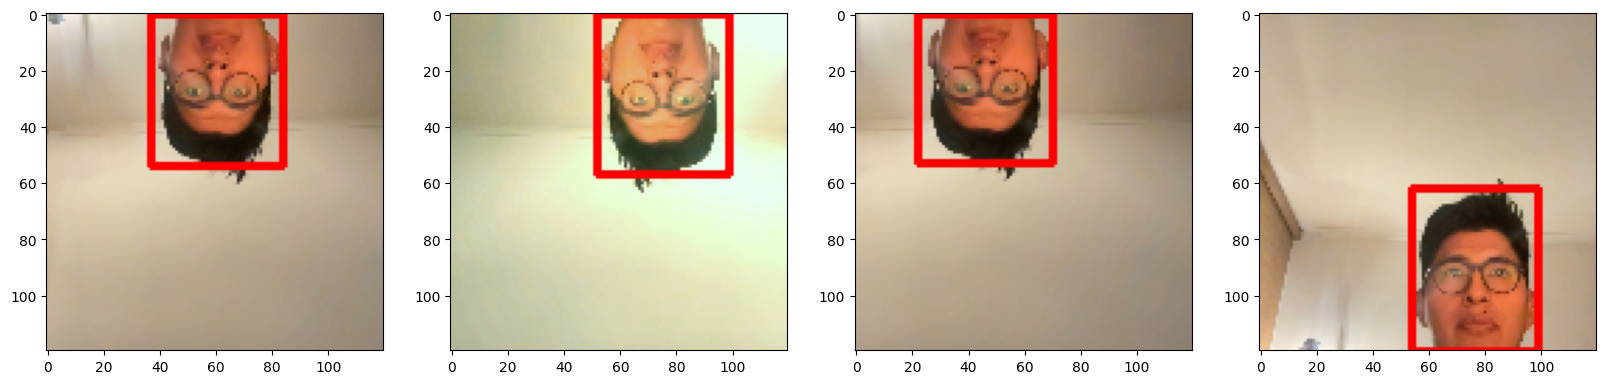

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using API

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## Download VGG16

In [51]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build instance of netwokr

In [54]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


### test model

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [57]:
X, y = train.as_numpy_iterator().next()


In [58]:
X.shape


(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

2023-01-09 00:21:27.677777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [60]:
classes, coords


(array([[0.619184  ],
        [0.66970307],
        [0.6046331 ],
        [0.7526775 ],
        [0.68785024],
        [0.7055395 ],
        [0.5576461 ],
        [0.5447781 ]], dtype=float32),
 array([[0.72285765, 0.47582477, 0.5124685 , 0.7846204 ],
        [0.7065181 , 0.39250478, 0.5438229 , 0.7082918 ],
        [0.73162264, 0.46660137, 0.49133432, 0.75213593],
        [0.7673484 , 0.3725521 , 0.465346  , 0.74718773],
        [0.719755  , 0.3765296 , 0.41982806, 0.70065945],
        [0.71807116, 0.40849406, 0.47401792, 0.6896502 ],
        [0.706654  , 0.43687963, 0.46073776, 0.71963847],
        [0.68167055, 0.5041322 , 0.45378703, 0.7220941 ]], dtype=float32))

# 9. Define losses and optimizers

In [61]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [63]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

## Create Localization loss and classification loss

In [64]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [65]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test out loss metrics

In [66]:
localization_loss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=5.232073>

In [67]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.4477385>

In [68]:
regressloss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=5.232073>

# 10. Train Neural Network

In [69]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)

In [71]:
model.compile(opt, classloss, regressloss)


## Train

In [72]:
logdir='logs'

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2023-01-09 00:31:02.580753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - total_loss: 5.4560 - class_loss: 0.4477 - regress_loss: 5.2322

2023-01-09 00:31:06.244399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - total_loss: 5.4560 - class_loss: 0.4477 - regress_loss: 5.2322 - val_total_loss: 0.5705 - val_class_loss: 0.1606 - val_regress_loss: 0.4902
Epoch 2/10
1/1 [==============================] - 0s 168ms/step - total_loss: 0.8992 - class_loss: 0.2273 - regress_loss: 0.7856 - val_total_loss: 0.4132 - val_class_loss: 0.0874 - val_regress_loss: 0.3695
Epoch 3/10
1/1 [==============================] - 0s 159ms/step - total_loss: 1.0909 - class_loss: 0.1108 - regress_loss: 1.0355 - val_total_loss: 0.3906 - val_class_loss: 0.1174 - val_regress_loss: 0.3319
Epoch 4/10
1/1 [==============================] - 0s 157ms/step - total_loss: 0.5327 - class_loss: 0.1325 - regress_loss: 0.4665 - val_total_loss: 0.5128 - val_class_loss: 0.1285 - val_regress_loss: 0.4485
Epoch 5/10
1/1 [==============================] - 0s 157ms/step - total_loss: 0.5564 - class_loss: 0.1388 - regress_loss: 0.4869 - val_total_loss: 0.4791 - val_class_loss: 0.1052 - val_regre

## Performance

In [75]:
hist.history

{'total_loss': [5.456037521362305,
  0.8992277979850769,
  1.0909178256988525,
  0.5327246785163879,
  0.5563502907752991,
  0.44826868176460266,
  0.3302597999572754,
  0.27934858202934265,
  0.2548449635505676,
  0.22046594321727753],
 'class_loss': [0.44773852825164795,
  0.22733093798160553,
  0.11082613468170166,
  0.13249769806861877,
  0.13880249857902527,
  0.11150054633617401,
  0.07902425527572632,
  0.05440612882375717,
  0.03887615352869034,
  0.029751557856798172],
 'regress_loss': [5.232168197631836,
  0.7855623364448547,
  1.035504698753357,
  0.46647584438323975,
  0.48694902658462524,
  0.39251840114593506,
  0.29074767231941223,
  0.25214552879333496,
  0.23540687561035156,
  0.205590158700943],
 'val_total_loss': [0.5704683661460876,
  0.41320040822029114,
  0.3906322717666626,
  0.5127878785133362,
  0.47913676500320435,
  0.3848811388015747,
  0.3224623203277588,
  0.29545387625694275,
  0.2834949791431427,
  0.279622882604599],
 'val_class_loss': [0.16055552661418

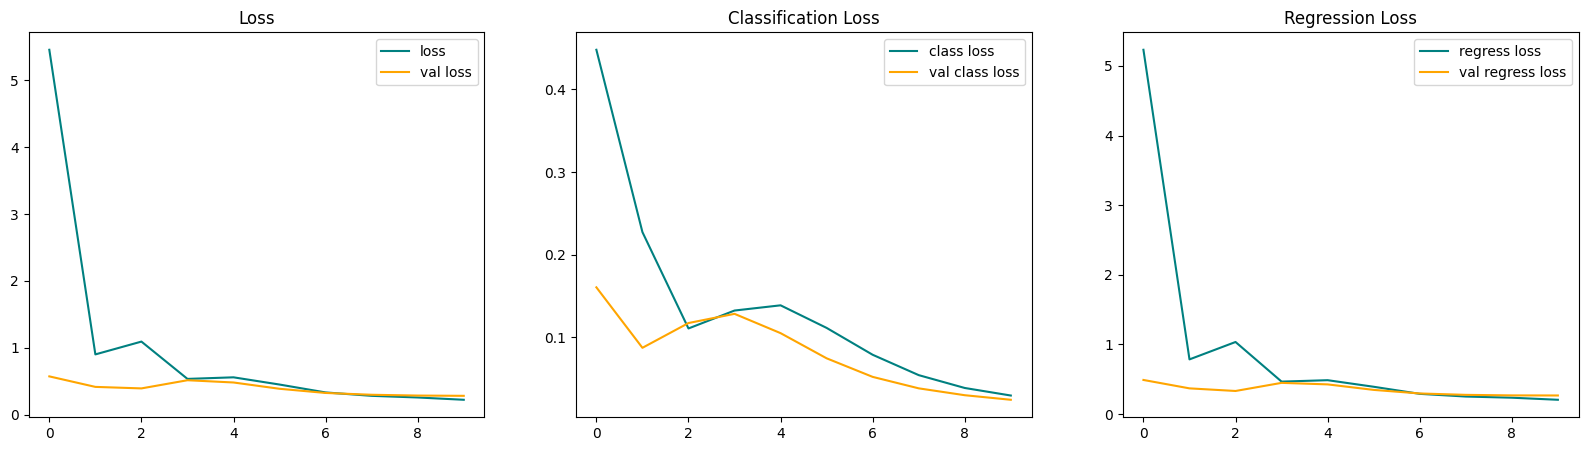

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

In [77]:
test_data = test.as_numpy_iterator()

In [78]:
test_sample = test_data.next()

In [79]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 129ms/step


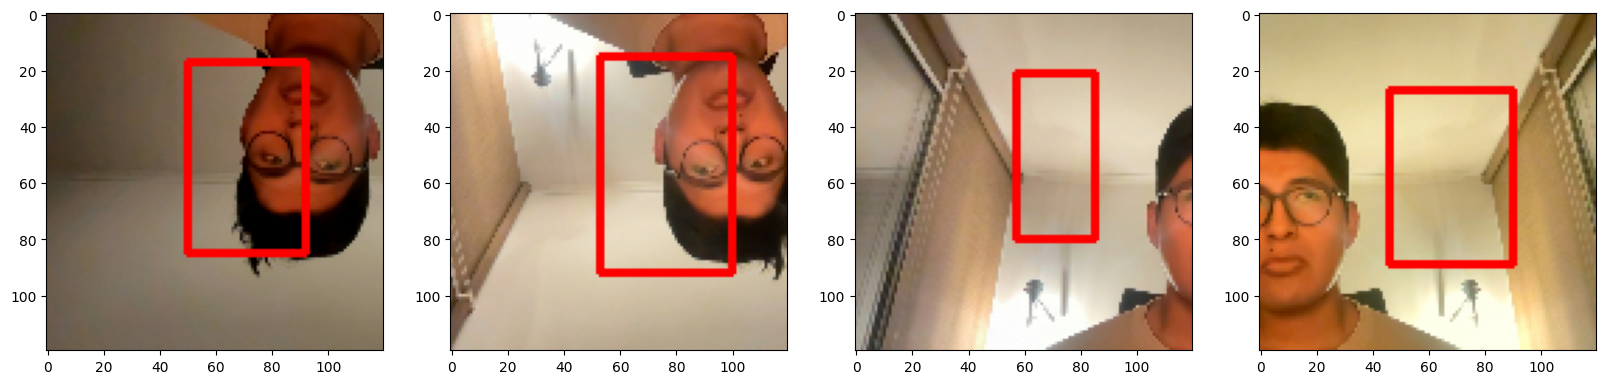

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Save Model

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [3]:
#facetracker.save('facetracker.h5')

In [4]:
facetracker = load_model('facetracker.h5')

Metal device set to: Apple M1 Pro


2023-01-09 00:36:58.788436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 00:36:58.788458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 12. Real Time Detection

In [5]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:1920, 50:1080,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                      (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [80,0])),
                      (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'pit_ql', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 168ms/step


2023-01-09 00:37:00.712863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-09 00:37:00.772637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
